<a href="https://colab.research.google.com/github/francesco-mannella/AdversarialWidhKeras/blob/master/notebooks/aae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [0]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
%matplotlib inline

from __future__ import division, print_function, absolute_import

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

seed = 1
rng = np.random.RandomState(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

In [0]:
from keras.datasets import mnist

(x_train, y_train), (_, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = 2*x_train - 1


Using TensorFlow backend.


#Build the graph
We build the Adversarial Autoencoder network. It is made of three networks: the encoder, the decoder and the discriminator.
Those networks are combined to run 
* an autoencoder network (**images**->**encoder**->**latents**->**decoder**->**generated_images**)
* a discriminator network (
    * **latents**->**discriminator**->**D_Probs**
    * **images**->**encoder**->**latents**->**discriminator**->**G_Propbs**
    
    )
* a generator network (**images**->**encoder**->**latents**->**discriminator**->**G_Probs**)

In [0]:
from tensorflow.keras.optimizers import Adam

class Autoencoder:
    def __init__(self, latent_num, dropout, w_stddev, autoencoder_rl, 
                 discriminator_rl, generator_rl):

        self.autoencoder_optimizer = Adam(autoencoder_rl, 0.5)
        self.discriminator_optimizer = Adam(discriminator_rl, 0.5)
        self.generator_optimizer = Adam(generator_rl, 0.5)

        def w_init(stddev):
            return keras.initializers.RandomNormal(mean=0.0, stddev=stddev)

        def dense(units, **kargs):
            return keras.layers.Dense(
                units=units,
                kernel_initializer=w_init(w_stddev),
                bias_initializer=w_init(w_stddev),
                **kargs)

        # encoder 
        self.encoder = keras.models.Sequential(name="encoder_net")
        self.encoder.add(keras.layers.Flatten())
        self.encoder.add(dense(1024, name="dL1"))
        self.encoder.add(keras.layers.ReLU())
        self.encoder.add(dense(1024, name="dL2"))
        self.encoder.add(keras.layers.ReLU())
        self.encoder.add(dense(256, name="dL3"))
        self.encoder.add(keras.layers.ReLU())
        self.encoder.add(dense(latent_num, name="encoded"))

        # decoder
        self.decoder = keras.models.Sequential(name="decoder_net")
        self.decoder.add(keras.layers.Input(shape=(latent_num,)))
        self.decoder.add(dense(256, name="gL1"))
        self.decoder.add(keras.layers.ReLU())
        self.decoder.add(dense(1024, name="gL2"))
        self.decoder.add(keras.layers.ReLU())
        self.decoder.add(dense(1024,  name="gL3"))
        self.decoder.add(keras.layers.ReLU())
        self.decoder.add(dense(28*28,  name="decoded"))
        self.decoder.add(keras.layers.Reshape((28, 28), name="unflattened_decoded"))

        # discriminator 
        self.discriminator = keras.models.Sequential(name="discriminator_net")
        self.discriminator.add(keras.layers.Input(shape=(latent_num,)))
        self.discriminator.add(keras.layers.Dropout(dropout))
        self.discriminator.add(dense(1024, name="dL1"))
        self.discriminator.add(keras.layers.ReLU())
        self.discriminator.add(keras.layers.Dropout(dropout))
        self.discriminator.add(dense(1024, name="dL2"))
        self.discriminator.add(keras.layers.ReLU())
        self.discriminator.add(keras.layers.Dropout(dropout))
        self.discriminator.add(dense(256, name="dL3"))
        self.discriminator.add(keras.layers.ReLU())
        self.discriminator.add(keras.layers.Dropout(dropout))
        self.discriminator.add(dense(1, activation="sigmoid", name="prob"))

        # reconstruction model
        img_input = keras.layers.Input(shape=(28, 28))
        encoded = self.encoder(img_input)
        decoded = self.decoder(encoded)
        self.autoencoder_model = keras.models.Model(name="autoencoder",
            inputs=img_input, outputs=decoded)
        self.autoencoder_model.compile(optimizer=self.autoencoder_optimizer,
                                    loss='mse')

        # discriminator model
        latents = keras.layers.Input(shape=(latent_num,))
        self.discriminator_model = keras.models.Model(name="discriminator",
            inputs=latents, outputs=self.discriminator(latents))
        self.discriminator_model.compile(optimizer=self.discriminator_optimizer,
                                    loss='binary_crossentropy')
        
        # generator model
        self.discriminator.trainable = False
        self.generator_model = keras.models.Model(name="generator",
            inputs=img_input, outputs=self.discriminator(encoded))
        self.generator_model.compile(optimizer=self.generator_optimizer,
                                loss='binary_crossentropy')
        


#Manage scheduling

In [0]:
def scheduling():
    img_indices = np.arange(x_train.shape[0])
    num_imgs = len(img_indices)
    batch_num = num_imgs//batch_size

    def noise(shape):
        if gaussian_prior == True:
            x = rng.normal(0,1, shape)
        else:
            x = rng.uniform(-1,1, shape)
        return x

    def get_test(dim):
        x = np.linspace(-5, 5, dim)
        X, Y = np.meshgrid(x, x)
        return np.vstack((X.ravel(), Y.ravel())).T
    test_dim = 16
    test = get_test(test_dim)

    return img_indices, batch_num, test, noise

#Init plots 

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import matplotlib.gridspec as gridspec
from PIL import Image
import glob, io

class Plotter:
    def init_plots(self):
        
        self.count = 0

        self.fig = plt.figure(figsize=(6,4.5), constrained_layout=True)
        gs = self.fig.add_gridspec(3, 4)

        ax1 = self.fig.add_subplot(gs[0,:])
        self.rlossl, = ax1.plot(0,0, c="blue")
        self.dlossl, = ax1.plot(0,0, c="red")
        self.alossl, = ax1.plot(0,0, c="green")
        ax1.set_xlim([0, num_epochs])
        ax1.set_ylim([0, rlim])

        ax2 = self.fig.add_subplot(gs[1:,:2], aspect="equal")
        self.digits = ax2.imshow(np.zeros([2, 2]), vmin=-1, vmax=1)
        ax2.set_axis_off()

        ax3 = self.fig.add_subplot(gs[1:,2:], aspect="equal")
        cols = plt.cm.hsv(np.linspace(0, 1, 10))
        self.points = []
        for k in range(10):
            self.points.append(ax3.scatter(0,0, color=cols[k], s=5, alpha=0.05))
        ax3.set_xlim([-5, 5])
        ax3.set_ylim([-5, 5])
        self.fig.tight_layout()
        clear_output()
        display(plt.gcf())    

    def update_plots(self, epoch, ae, data):

        rloss, dloss, aloss, test = data

        test_dim = int(np.sqrt(test.shape[0]))

        self.rlossl.set_data(np.arange(epoch+1), np.hstack(rloss)*rlim)
        self.dlossl.set_data(np.arange(epoch+1), dloss)
        self.alossl.set_data(np.arange(epoch+1), aloss)

        test_gen_batch = ae.decoder.predict(test).reshape(test_dim, test_dim, 28,28)
        self.digits.set_data(np.vstack([ np.hstack([img for img in test_gen_row])
            for test_gen_row in test_gen_batch[::-1]]))

        test_latents = ae.encoder.predict(x_train)

        for k in range(10):
            digit_latents = test_latents[np.where(y_train==k)[0]]
            self.points[k].set_offsets(digit_latents)

        clear_output()
        print("epoch: %-10d\nrloss: %-10.7f  dloss: %-10.7f aloss: %-10.7f" % (
            epoch, rloss[-1], dloss[-1], aloss[-1]))
        display(plt.gcf())

        self.fig.savefig("aae-%06d.png"%self.count)
        self.count += 1

        
        # Open all the frames
        image_names = sorted(glob.glob("aae*.png"))
        if len(image_names) > 1:
            images = []

            for img_name in image_names:
                with open(img_name, "rb") as f:
                    frame = Image.open(io.BytesIO(f.read()))
                images.append(frame)
            #save the frames as an animated GIF
            images[0].save('aae.gif',
                    save_all=True,
                    append_images=images[1:],
                    duration=500,
                    loop=0)
plotter = Plotter()

#Train

In [0]:
def run():

    ae = Autoencoder(latent_num, dropout, w_stddev, 
                    autoencoder_rl, discriminator_rl, generator_rl)


    plotter.init_plots()
    img_indices, batch_num, test, noise = scheduling()

    rloss = []
    dloss = []
    aloss = []
    for epoch in range(num_epochs):
        rng.shuffle(img_indices)
        train_imgs = x_train[img_indices,...]
        epoch_rloss = [] 
        epoch_dloss = [] 
        epoch_aloss = [] 

        for batch in range(batch_num):
            
            curr_rloss, curr_aloss, curr_dloss = [0, 0, 0]

            real_images = train_imgs[batch*batch_size:(batch + 1)*batch_size]
            
            discr_batch_size = int(batch_size*batch_props[1])
            gen_batch_size = int(batch_size*batch_props[2])
            ae_batch_size = batch_size - (discr_batch_size + gen_batch_size)
            
            autoencoder_images = real_images[:ae_batch_size]
            autoencoder_noise = ae_noise*rng.randn(*autoencoder_images.shape)

            curr_rloss = ae.autoencoder_model.train_on_batch(
                    autoencoder_images + autoencoder_noise,
                    autoencoder_images)

            adversarial_images = real_images[ae_batch_size:(ae_batch_size + discr_batch_size)] 
            adversarial_latents = ae.encoder.predict(adversarial_images)
            prior_decay = 0*np.exp(-epoch/(num_epochs*2))
            discriminator_latents = prior_std*(1 + prior_decay)*noise(adversarial_latents.shape) 

            curr_dloss = ae.discriminator_model.train_on_batch(
                    np.vstack((discriminator_latents, adversarial_latents)), 
                    np.hstack((np.ones(discr_batch_size), np.zeros(discr_batch_size))))
            
            generator_images = real_images[discr_batch_size:(discr_batch_size + gen_batch_size)] 
            curr_aloss = ae.generator_model.train_on_batch(
                generator_images, 
                np.ones(gen_batch_size))
            
            epoch_rloss.append(curr_rloss)
            epoch_dloss.append(curr_dloss)
            epoch_aloss.append(curr_aloss)
            
        rloss.append(np.mean(epoch_rloss))
        dloss.append(np.mean(epoch_dloss))
        aloss.append(np.mean(epoch_aloss))
        
        if epoch%epochs_to_show == 0 or epoch == (num_epochs - 1):    
            plotter.update_plots(epoch, ae, [rloss, dloss, aloss, test])

#Session

In [0]:
#@title
dropout = 0.3
ae_noise = 0.01
latent_num = 2
w_stddev = 0.01
autoencoder_rl = 2e-4
discriminator_rl = 2e-4
generator_rl = 2e-4

num_epochs  = 300
batch_size = 300
batch_props = [.33, .33, .33]
epochs_to_show = 10
gaussian_prior = True
prior_std = 1.0

rlim = 1

print("""
dropout: {:}
ae_noise: {:}
latent_num: {:}
w_stddev: {:}
autoencoder_rl: {:2.0e}
discriminator_rl: {:2.0e}
generator_rl: {:2.0e}

num_epochs: {:}  
batch_size: {:}
batch_props: {:}
epochs_to_show: {:}
gaussian_prior: {:}
prior_std: {:6.4f}
""".format(
    dropout,
    ae_noise,
    latent_num,
    w_stddev,
    autoencoder_rl,
    discriminator_rl,
    generator_rl,
    num_epochs,  
    batch_size,
    batch_props, 
    epochs_to_show, 
    gaussian_prior,
    prior_std))


dropout: 0.3
ae_noise: 0.01
latent_num: 2
w_stddev: 0.01
autoencoder_rl: 2e-04
discriminator_rl: 2e-04
generator_rl: 2e-04

num_epochs: 300  
batch_size: 300
batch_props: [0.33, 0.33, 0.33]
epochs_to_show: 10
gaussian_prior: True
prior_std: 1.0000



epoch: 230       
rloss: 0.1451451   dloss: 0.6931593  aloss: 0.6931384 


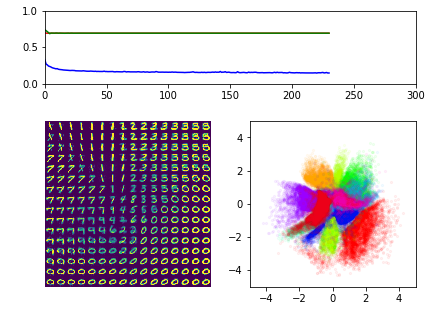

In [0]:
run()